In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from string import letters
%matplotlib inline

sns.set(style="white")

# Read a dataset
d=pd.read_csv('training_set.csv',header=None,index_col=False)

#d.iloc[:,range(40)+[58]]
d.columns = ['id']+range(60)
d.index = d['id']
d=d.drop('id',1)
d_full=d

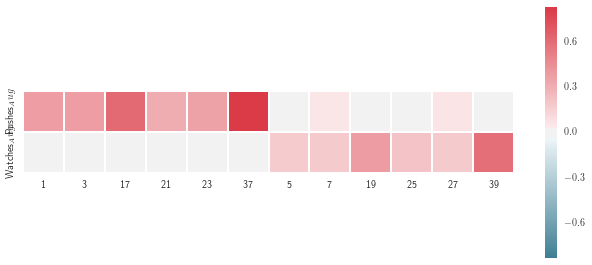

In [6]:
# Compute the correlation matrix
corr = d.ix[:,range(40)+[57,59]].corr()
corr = corr.ix[[57,59],[1,3,17,21,23,37,5,7,19,25,27,39]]
corr.index=['Pushes_Aug','Watches_Aug']
# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
#mask[0:40,:] = True
#mask[:,40:] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, #vmax=.5,
            square=True, #xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

f.savefig('corr.pdf')

In [8]:
corr.ix[57:59,[1,3,]]

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,57,59
57,0.026523,0.382432,0.029418,0.381757,0.019768,0.004132,-0.000069,0.057001,0.022142,0.008306,...,0.003134,0.084423,0.084075,0.036050,0.062260,0.837743,0.000699,0.004328,1.000000,0.007966
59,0.029673,-0.002318,-0.000156,-0.001590,-0.002688,0.174392,0.014038,0.176788,0.151318,0.072125,...,0.010951,0.121518,0.126156,0.063244,0.087799,-0.000783,0.003251,0.593882,0.007966,1.000000


In [10]:
corr = d.ix[:,range(40)+[57,59]].corr()
corr.ix[57,corr.ix[57,:]>0.2]


1     0.382432
3     0.381757
17    0.626436
21    0.315586
23    0.363316
37    0.837743
57    1.000000
Name: 57, dtype: float64

In [2]:
## Train something

#dataset is randomized already, so take first half for training, second half for testing
#first remove anomalous number of commits

jun_tot=d.ix[:,0:20].sum(1)
jul_tot=d.ix[:,20:40].sum(1)
aug_tot=d.ix[:,40:60].sum(1)

quality_repo=jun_tot&jul_tot

event_req=((d_full.ix[:,range(40)]>0).sum(1)>7) & (d_full.ix[:,[13,14,15,33,34,35]].sum(1)>=2)

d=d_full.ix[(event_req) & (jun_tot>=100) & (jul_tot>=100),:]
#d=d_full

num_entries=d.shape[0]
print num_entries
row_index=list(d.index)
training_rows = row_index[:num_entries/2]
testing_rows = row_index[num_entries/2:]

#first 40 columns are the predictors of the model
predictor_col=range(40) # [1,3,17,21,23,37] 
#target is the number of pushes in August
target_col=[59]

#Make training and testing sets
X_train=d.ix[training_rows,predictor_col]
#y_train=d.ix[training_rows,40:60].sum(1)
y_train=d.ix[training_rows,target_col]
y_train=np.array(y_train.transpose())[0]

X_test=d.ix[testing_rows,predictor_col]
#y_test=d.ix[testing_rows,40:60].sum(1)
y_test=d.ix[testing_rows,target_col]
y_test=np.array(y_test.transpose())[0]


6792


In [3]:
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [20]:
# Fit Linear model

lin_reg = LinearRegression()
lin_reg.fit(X_train.ix[:,[13,14,17,33,34,37]], y_train)
#lin_reg.fit(X_train.ix[:,[9,19,29,39]], y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [342]:
# Fit GLM Model
import statsmodels.api as sm

poisson_model = sm.GLM(y_train, X_train.ix[:,[17,37]], family=sm.families.Gamma())
poisson_result = poisson_model.fit()


In [297]:
# Fit RandomForest
rf=RandomForestRegressor(n_estimators=1000, min_samples_split=2, n_jobs=2, max_depth=6)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [21]:
from sklearn.metrics import mean_squared_error
res1=clf.predict(X_test)
res1[res1<0]=0
res2=lin_reg.predict(X_test.ix[:,[13,14,17,33,34,37]])
#res2=lin_reg.predict(X_test.ix[:,[9,19,29,39]])
res2[res2<0]=0
res3=X_test.ix[:,37]
#res3=X_test.ix[:,39]
res=(res1+res2+res3)/3.
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
mse = mean_squared_error(y_test, lin_reg.predict(X_test.ix[:,[13,14,17,33,34,37]]))
#mse = mean_squared_error(y_test, lin_reg.predict(X_test.ix[:,[9,19,29,39]]))
print("MSE: %.4f" % mse)
mse = mean_squared_error(y_test, X_test.ix[:,[37]])
#mse = mean_squared_error(y_test, X_test.ix[:,[39]])
print("MSE: %.4f" % mse)
mse = mean_squared_error(y_test, res)
print("MSE: %.4f" % mse)

MSE: 3699.3047
MSE: 3895.4964
MSE: 3167.6331
MSE: 2786.4785


In [664]:
# Save the work
from sklearn.externals import joblib
joblib.dump(clf,'gradientboostedregression_pushes.pkl')
joblib.dump(lin_reg,'linearregression_pushes.pkl')

['linearregression_pushes.pkl',
 'linearregression_pushes.pkl_01.npy',
 'linearregression_pushes.pkl_02.npy']

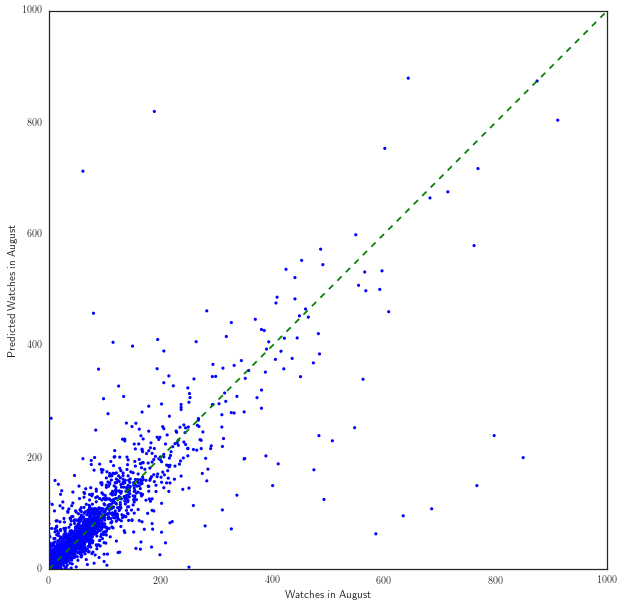

In [38]:
del fig, ax1
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

## the data
N = len(y_test)
x = y_test
#y=res
#y = y_test-poisson_results.predict(X_test)
y = clf.predict(X_test)
#y=rf.predict(X_train)
#y = lin_reg.predict(X_test.ix[:,[13,14,17,33,34,37]])
#y=poisson_result.predict(X_test.ix[testing_rows,[17,37]])


#jun=np.array(X_test.ix[:,[17]].transpose())[0]
#jul=np.array(X_test.ix[:,[37]].transpose())[0]
#aug=y_test
jun=d.ix[testing_rows,0:20].sum(1)
jul=d.ix[testing_rows,20:40].sum(1)
aug=d.ix[testing_rows,40:60].sum(1)

## left panel
ax1.scatter(x,y,color='blue',s=10,edgecolor='none')
#ax1.scatter(jun,aug,color='blue',s=5,edgecolor='none')
#ax1.scatter(jul,aug,color='green',s=5,edgecolor='none')
#ax1.set_aspect(1./ax1.get_data_ratio()) # make axes square
ax1.plot([0,1000],[0,1000], "r--",label='good',color='green')
ax1.set_ylim([0,1000])
ax1.set_xlim([0,1000])
plt.xlabel('Watches in August')
plt.ylabel('Predicted Watches in August')
plt.show()


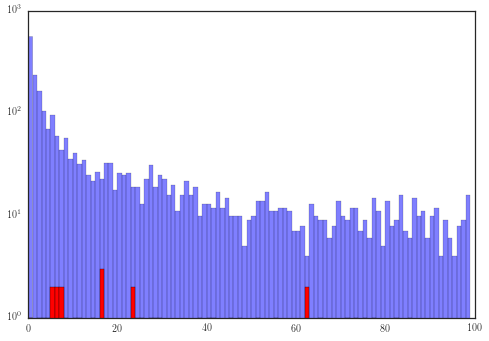

In [570]:
#Try to find anamolies
anom=d.ix[training_rows,39]*2+10<d.ix[training_rows,59]
not_anom=d.ix[training_rows,39]*2+10>d.ix[training_rows,59]


fig = plt.figure()
ax = fig.add_subplot(111)

col=39
numBins = 50
plt.gca().set_yscale("log")
ax.hist(np.array(X_train.ix[not_anom,col]),bins=range(0,100),color='blue',alpha=0.5)
ax.hist(np.array(X_train.ix[anom,col]),bins=range(0,100),color='red',alpha=1.0)
#ax.set_xlim([0,2000])
plt.show()


In [586]:
#Calculate classifier
anom=d.ix[training_rows,39]*2+10<d.ix[training_rows,59]
not_anom=d.ix[training_rows,39]*2+10>d.ix[training_rows,59]

anom_pred=(d.ix[training_rows,0]<5)&(d.ix[training_rows,1]<10)&(d.ix[training_rows,2]<5)&(d.ix[training_rows,3]<10)&(d.ix[training_rows,4]<1)&(d.ix[training_rows,5]<15)&(d.ix[training_rows,6]<5)&(d.ix[training_rows,8]<20)&(d.ix[training_rows,9]<20)&(d.ix[training_rows,10]<5)&(d.ix[training_rows,11]<3)&(d.ix[training_rows,12]<2)&(d.ix[training_rows,13]<20)&(d.ix[training_rows,14]<20)&(d.ix[training_rows,15]<3)&(d.ix[training_rows,16]<10)&(d.ix[training_rows,17]<50)&(d.ix[training_rows,18]<5)&(d.ix[training_rows,20]<5)&(d.ix[training_rows,21]<20)&(d.ix[training_rows,22]<5)&(d.ix[training_rows,23]<10)&(d.ix[training_rows,24]<2)&(d.ix[training_rows,25]<20)&(d.ix[training_rows,26]<10)&(d.ix[training_rows,28]<30)&(d.ix[training_rows,30]<5)&(d.ix[training_rows,31]<3)&(d.ix[training_rows,32]<3)&(d.ix[training_rows,33]<30)&(d.ix[training_rows,34]<30)&(d.ix[training_rows,35]<4)&(d.ix[training_rows,36]<20)&(d.ix[training_rows,37]<50)&(d.ix[training_rows,38]<5)

print sum(anom_pred)
print sum(anom)
print sum((anom_pred==anom) &(anom==1))


290
49
11


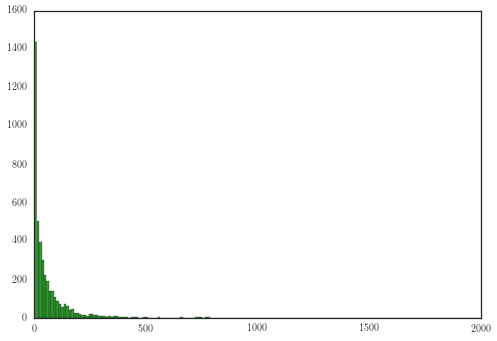

21756


TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [201]:
fig = plt.figure()
ax = fig.add_subplot(111)

numBins = 2000
ax.hist(list(d.ix[testing_rows,57]),numBins,color='green',alpha=0.8)
ax.set_xlim([0,2000])
plt.show()
print max(list(d.ix[training_rows,57]))
print d[d.ix[training_rows,57] >20000,:].index

(array([  489.,   760.,  3816.,  1856.,  2356.,  2174.,  2816.,  2325.,
         2305.,  2174.,  2464.,  2307.,  2288.,  2491.,  2461.,  2370.,
         2376.,  2229.,  2022.,  1760.,  1513.,  1225.,  1119.,   853.,
          665.,   912.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.]),
 <a list of 26 Patch objects>)

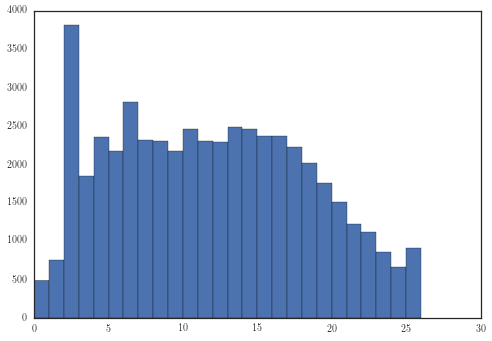

In [252]:
#d_full.ix[list((d_full.ix[:,57] >1000)&(d_full.ix[:,41] >0)&(d_full.ix[:,53] >0)),40:60].transpose()
#plt.hist(list((d_full.ix[:,[0,1,2,3,4,7,8,9,13,14,16,17,19,20,21,22,23,24,27,28,29,33,34,36,37,39]]>0).sum(1)),26,[0,26])
plt.hist(list((d_full.ix[:,range(40)]>0).sum(1)),26,[0,26])


In [312]:
import statsmodels.api as sm
data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)

# Instantiate a gamma family model with the default link function.
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
gamma_results = gamma_model.fit()

In [72]:
y_aug=d.ix[testing_rows,59]
y_jul=d.ix[testing_rows,39]
y_pred=clf.predict(X_test)

for a in [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]:
    for b in [0,2,4,6,8,10,12,14,16,18,20]:
        hot_pred=(y_pred>np.where(y_jul < 100, 100, a*y_test+b))
        hot_true=(y_aug >np.where(y_jul < 100, 100, a*y_test+b))
        
        true_pos=(hot_pred==1)&(hot_true==1)
        true_neg=(hot_pred==0)&(hot_true==1)
        false_pos=(hot_pred==1)&(hot_true==0)
        false_neg=(hot_pred==0)&(hot_true==0)
        
        num_true_pos=0
        for i in true_pos:
            if i:
                num_true_pos+=1
        num_true_neg=0
        for i in true_neg:
            if i:
                num_true_neg+=1
        num_false_pos=0
        for i in false_pos:
            if i:
                num_false_pos+=1
        num_false_neg=0
        for i in false_neg:
            if i:
                num_false_neg+=1

        #print "%d %d %d %d" % (num_true_pos, num_true_neg, num_false_pos, num_false_neg)
        precision=(float(num_true_pos)/(num_true_pos+num_false_pos))
        recall=(float(num_true_pos)/(num_true_pos+num_false_neg))
        F1 = 2*precision*recall/(precision+recall)
        print "P,R,F1,a,b = %.2f,%.2f,%.2f,%.1f,%d" % (precision, recall, F1 , a, b)



P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,0,0
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,0,20
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,0,40
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,0,60
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,0,80
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,0,100
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,5,0
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,5,20
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,5,40
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,5,60
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,5,80
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,5,100
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,10,0
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,10,20
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,10,40
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,10,60
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,10,80
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,10,100
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,15,0
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,15,20
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,15,40
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,15,60
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,15,80
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,15,100
P,R,F1,a,b,c = 0.03,0.00,0.01,1.0,20,0
P,R,F1,a,b,c 

49
3396


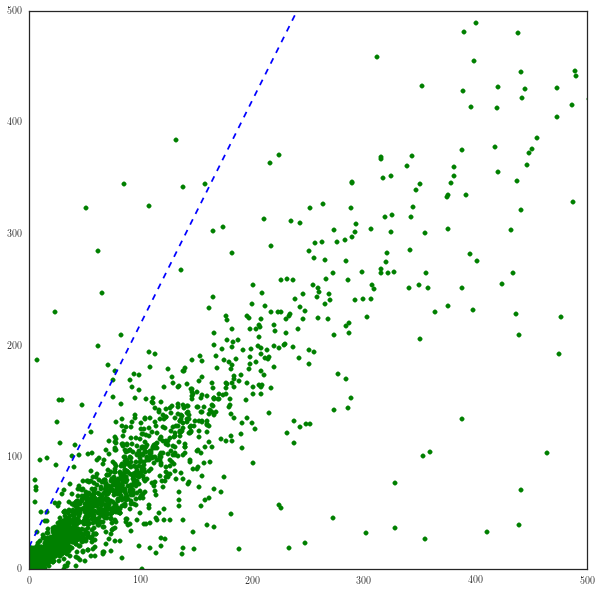

In [430]:
import math
print sum(np.array(d.ix[training_rows,39]*2+10<d.ix[training_rows,59]))
print len(training_rows)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(d.ix[training_rows,39],d.ix[training_rows,59],color='green')
ax.set_xlim([0,500])
ax.set_ylim([0,500])
ax.plot([0,1000],[20,2020], "r--",label='test',color='blue')
plt.show()



In [92]:
# Fit regression model
params = {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 1,
          'learning_rate': 0.1}
clf = GradientBoostingClassifier(**params)

labels=y_train>X_train.ix[:,39]
clf.fit(X_train, labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [93]:
labels=y_test>X_test.ix[:,39]
y_pred=clf.predict(X_test)
y_true=labels

true_pos=(y_pred==1)&(y_true==1)
true_neg=(y_pred==0)&(y_true==1)
false_pos=(y_pred==1)&(y_true==0)
false_neg=(y_pred==0)&(y_true==0)

num_true_pos=0
for i in true_pos:
    if i:
        num_true_pos+=1
num_true_neg=0
for i in true_neg:
    if i:
        num_true_neg+=1
num_false_pos=0
for i in false_pos:
    if i:
        num_false_pos+=1
num_false_neg=0
for i in false_neg:
    if i:
        num_false_neg+=1

#print "%d %d %d %d" % (num_true_pos, num_true_neg, num_false_pos, num_false_neg)
precision=(float(num_true_pos)/(num_true_pos+num_false_pos))
recall=(float(num_true_pos)/(num_true_pos+num_false_neg))
F1 = 2*precision*recall/(precision+recall)
print "P,R,F1,a,b = %.2f,%.2f,%.2f" % (precision, recall, F1)

ctr=0
label=y_train>X_train.ix[:,39]
for i in label:
    if i:
        ctr+=1
ctr

P,R,F1,a,b = 0.49,0.15,0.23


1124

In [84]:
y_pred

array([False, False,  True, ..., False,  True, False], dtype=bool)